# Fraud_Detection_Without_Oversampling

I am able to achieve the following accuracies in the validation data. but ROC_AUC_SCORE is not acceptable. 
Using over-sampling technique improved results substantially. These results can be further improved by reducing the 
parameter, number of frauds used to create features from category items. Currently, I have used a threshold of 100.

* Logistic Regression : 
        Validation Accuracy: 96.4%, ROC_AUC_Score: 50.2%
                
* Random Forest : 
        Validation Accuracy: 97.8%, ROC_AUC_Score: 70.9%
                
* Linear Support Vector Machine : 
        Validation Accuracy: 96.4%, ROC_AUC_Score: 50.3%
                
* K Nearest Neighbors : 
        Validation Accuracy: 96.4%, ROC_AUC_Score: 50.6%
                
* Extra Trees Classifer : 
        Validation Accuracy: 98.0%, ROC_AUC_Score: 78.7%

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm, neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
% matplotlib inline

C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Loading Training Transactions Data

In [2]:
tr_tr = pd.read_csv('data/train_transaction.csv', index_col='TransactionID')
print('Rows :', tr_tr.shape[0],'  Columns : ',tr_tr.shape[1] )
tr_tr.tail()
print('Memory Usage : ', (tr_tr.memory_usage(deep=True).sum()/1024).round(0))
tr_tr.tail()

Rows : 590540   Columns :  393
Memory Usage :  2162614.0


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
tr_id = pd.read_csv('data/train_identity.csv', index_col='TransactionID')
print(tr_id.shape)
tr_id.tail()

(144233, 40)


,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,NaN,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,0.0,...,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS
3577534,-45.0,339406.0,NaN,NaN,-10.0,-100.0,NaN,NaN,NaN,NaN,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,RNE-L03 Build/HUAWEIRNE-L03


In [4]:
tr = tr_tr.join(tr_id)
tr['data']='train'
print(tr.shape)
tr.head()

(590540, 434)


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,data
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,train


In [5]:
del tr_tr
del tr_id

In [6]:
te_tr = pd.read_csv('data/test_transaction.csv', index_col='TransactionID')
print(te_tr.shape)
te_tr.tail()

(506691, 392)


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4170238,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4170239,34214345,24.346,C,5713,168.0,144.0,visa,147.0,credit,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
te_id = pd.read_csv('data/test_identity.csv', index_col='TransactionID')
print(te_id.shape)
te_id.tail()

(141907, 40)


,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
4170230,-20.0,473365.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,chrome 71.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-J700M
4170233,-5.0,489917.0,0.0,0.0,-4.0,-32.0,NaN,NaN,0.0,0.0,...,chrome 71.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-J320M
4170234,-5.0,110081.0,NaN,NaN,22.0,-31.0,NaN,NaN,NaN,NaN,...,mobile safari 10.0,32.0,1334x750,match_status:2,T,F,F,T,mobile,iOS Device
4170236,-45.0,266704.0,NaN,NaN,-3.0,-10.0,NaN,NaN,NaN,NaN,...,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
4170239,-10.0,692090.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,samsung browser 8.2,NaN,NaN,NaN,F,F,T,F,mobile,SAMSUNG


In [8]:
te = te_tr.join(te_id)
te['data']='test'
te['isFraud']=2
print(te.shape)
te.head()

(506691, 434)


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,data,isFraud
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,2
3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,2
3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,2
3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,2
3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,2


In [9]:
del te_tr
del te_id

In [10]:
tr.isFraud.describe()

count    590540.000000
mean          0.034990
std           0.183755
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: isFraud, dtype: float64

0    569877
1     20663
Name: isFraud, dtype: int64

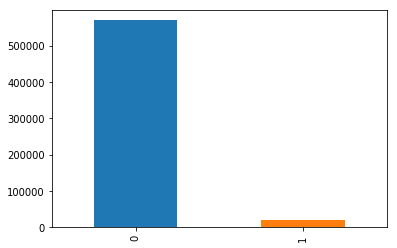

In [11]:
tr.isFraud.value_counts().plot(kind='bar')
tr.isFraud.value_counts()

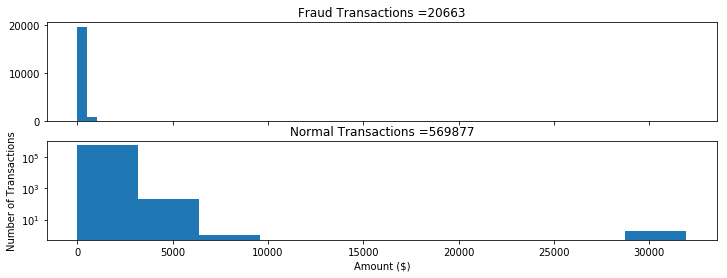

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.hist(tr.TransactionAmt[tr.isFraud == 1], bins = 10)
ax1.set_title('Fraud Transactions ='+str(tr.isFraud.value_counts()[1]))
ax2.hist(tr.TransactionAmt[tr.isFraud == 0], bins = 10)
ax2.set_title('Normal Transactions ='+str(tr.isFraud.value_counts()[0]))
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


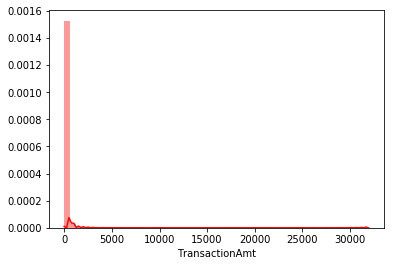

In [13]:
sns.distplot(tr['TransactionAmt'], color='red')

C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, *

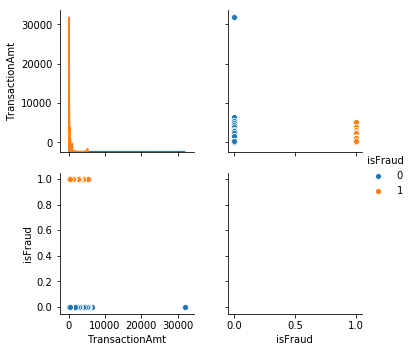

In [14]:
sns.pairplot(tr[['TransactionAmt','isFraud']], hue='isFraud')

In [15]:
df = pd.concat([tr,te], sort=False)
print(df.shape)
df.head()

(1097231, 434)


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,data
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,train


In [16]:
del tr
del te

### Make new category for items in Objects with A Fraud Count of more than 100

In [17]:
fraud_threshold = 100

def map_categories(*args):
    columns = [col for col in args]
    for column in columns:
        if column == index:
            return 1
        else:
            return 0
new_categories = []
for i in df.columns:
    if i != 'data':
        if df[i].dtypes == str('object'):
            fraud_count = df[df.isFraud==1][i].value_counts(dropna=False)
            for index, value in fraud_count.items():
                if value>fraud_threshold:
                    df[(str(i)+'_'+str(index))]=list(map(map_categories, df[i]))
                    new_categories.append((str(i)+'_'+str(index)))
    #             else:
    #                 tr[(str(i)+'_'+str('other'))]=list(map(map_categories, tr[i]))
    #                 new_tr_categories.append((str(i)+'_'+str('other')))
            df.drop([i], axis=1, inplace=True)
print(new_categories)
print(df.shape)
df.head()

['ProductCD_W', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'card4_visa', 'card4_mastercard', 'card4_discover', 'card4_american express', 'card6_debit', 'card6_credit', 'P_emaildomain_gmail.com', 'P_emaildomain_nan', 'P_emaildomain_hotmail.com', 'P_emaildomain_yahoo.com', 'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com', 'P_emaildomain_outlook.com', 'P_emaildomain_comcast.net', 'P_emaildomain_icloud.com', 'P_emaildomain_mail.com', 'R_emaildomain_nan', 'R_emaildomain_gmail.com', 'R_emaildomain_hotmail.com', 'R_emaildomain_yahoo.com', 'R_emaildomain_anonymous.com', 'R_emaildomain_outlook.com', 'R_emaildomain_icloud.com', 'R_emaildomain_aol.com', 'M1_nan', 'M1_T', 'M2_nan', 'M2_T', 'M2_F', 'M3_nan', 'M3_T', 'M3_F', 'M4_M0', 'M4_M2', 'M4_nan', 'M4_M1', 'M5_nan', 'M5_T', 'M5_F', 'M6_nan', 'M6_F', 'M6_T', 'M7_nan', 'M7_F', 'M7_T', 'M8_nan', 'M8_F', 'M8_T', 'M9_nan', 'M9_T', 'M9_F', 'id_12_NotFound', 'id_12_nan', 'id_12_Found', 'id_15_nan', 'id_15_Found', 'id_15_New', 'i

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,DeviceType_nan,DeviceType_mobile,DeviceType_desktop,DeviceInfo_nan,DeviceInfo_Windows,DeviceInfo_iOS Device,DeviceInfo_MacOS,DeviceInfo_hi6210sft Build/MRA58K,DeviceInfo_SM-A300H Build/LRX22G,DeviceInfo_rv:57.0
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,0,0,0,0,0,0,0,0,0,0
2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,...,0,0,0,0,0,0,0,0,0,0
2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,...,0,1,0,0,0,0,0,0,0,0


In [18]:
df.isna().any().mean()

0.7262773722627737

In [19]:
df.fillna(0, inplace=True)
df.isna().any().mean()

0.0

In [20]:
X = df[df['data'] == 'train'].drop(['isFraud','data'], axis=1)
y = df[df['data'] == 'train']['isFraud']

In [21]:
X_predict = df[df['data'] == 'test'].drop(['isFraud','data'], axis=1)

In [22]:
print(X.shape, y.shape, X_predict.shape)

(590540, 546) (590540,) (506691, 546)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [24]:
class_names = ['FRAUD', 'NORMAL']


def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Logistic Regression

In [25]:
lr = LogisticRegression(solver='lbfgs')
clf_lr = lr.fit(X_train, y_train)
confidence_lr=clf_lr.score(X_test, y_test)
print('Accuracy on Validation Data : ', confidence_lr.round(3)*100,'%')

Accuracy on Validation Data :  96.39999999999999 %


### Metrics on Validations Data

ROC_AUC_SCORE ;  50.2 %
[[170742    114]
 [  6281     25]]


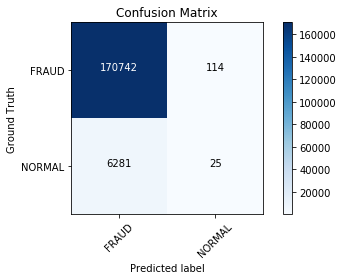

In [26]:
test_prediction = clf_lr.predict(X_test)
print('ROC_AUC_SCORE ; ', roc_auc_score(y_test, test_prediction).round(3)*100,'%')
cnf_matrix = confusion_matrix(y_test, test_prediction)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

### Prediction on Unseen Data

In [27]:
prediction_lr = clf_lr.predict(X_predict)
test = df[df['data'] == 'test']
del df
test['prediction_lr'] = prediction_lr

In [28]:
test.prediction_lr.value_counts()

0    506606
1        85
Name: prediction_lr, dtype: int64

In [29]:
test.prediction_lr.to_csv('Logistic_Regression_Prediction.csv')

## Random Forest

In [30]:
rfor=RandomForestClassifier()
clf_rfor = rfor.fit(X_train, y_train)
confidence_rfor=clf_rfor.score(X_test, y_test)
print('Accuracy on Validation Data : ', confidence_rfor.round(3)*100,'%')

Accuracy on Validation Data :  97.8 %


### Metrics on Validations Data

ROC_AUC_SCORE ;  70.89999999999999 %
[[170692    164]
 [  3664   2642]]


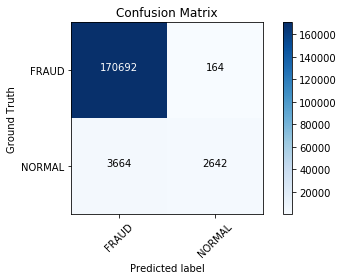

In [31]:
test_prediction = clf_rfor.predict(X_test)
print('ROC_AUC_SCORE ; ', roc_auc_score(y_test, test_prediction).round(3)*100,'%')
cnf_matrix = confusion_matrix(y_test, test_prediction)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

### Prediction on Unseen Data

In [32]:
prediction_rfor = clf_rfor.predict(X_predict)
test['prediction_rfor'] = prediction_rfor

In [33]:
test.prediction_rfor.value_counts()

0    499006
1      7685
Name: prediction_rfor, dtype: int64

In [34]:
test.prediction_rfor.to_csv('Random_Forest_Prediction.csv')

## Linear Support Vector Machine Algorithm

In [35]:
lsvc=svm.LinearSVC()
clf_lsvc=lsvc.fit(X_train, y_train)
confidence_lsvc=clf_lsvc.score(X_test, y_test)
print('Accuracy on Validation Data : ', confidence_lsvc.round(3)*100,'%')

Accuracy on Validation Data :  96.39999999999999 %


ROC_AUC_SCORE ;  50.3 %
[[170652    204]
 [  6257     49]]


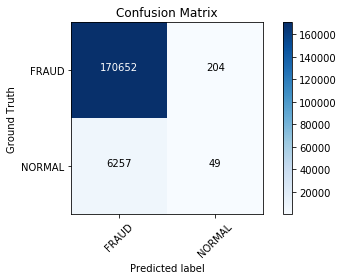

In [36]:
test_prediction = clf_lsvc.predict(X_test)
print('ROC_AUC_SCORE ; ', roc_auc_score(y_test, test_prediction).round(3)*100,'%')
cnf_matrix = confusion_matrix(y_test, test_prediction)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

## K-Nearest Neighbors Algorithm

In [37]:
knn=neighbors.KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
clf_knn=knn.fit(X_train, y_train)
confidence_knn=clf_knn.score(X_test, y_test)
print('Accuracy on Validation Data : ', confidence_knn.round(3)*100,'%')

Accuracy on Validation Data :  96.39999999999999 %


ROC_AUC_SCORE ;  50.6 %
[[170789     67]
 [  6227     79]]


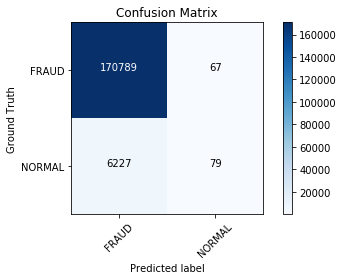

In [38]:
test_prediction = clf_knn.predict(X_test)
print('ROC_AUC_SCORE ; ', roc_auc_score(y_test, test_prediction).round(3)*100,'%')
cnf_matrix = confusion_matrix(y_test, test_prediction)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

## Extra Trees Classifier

In [39]:
etc=ExtraTreesClassifier()
clf_etc = etc.fit(X_train, y_train)
confidence_etc=clf_etc.score(X_test, y_test)
print('Accuracy on Validation Data : ', confidence_etc.round(3)*100,'%')

Accuracy on Validation Data :  98.0 %


### Metrics on Validations Data

ROC_AUC_SCORE ;  72.7 %
[[170682    174]
 [  3440   2866]]


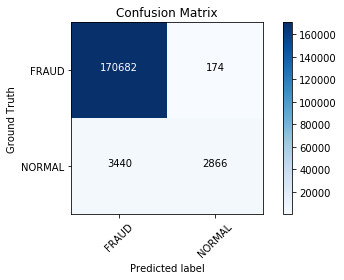

In [40]:
test_prediction = clf_etc.predict(X_test)
print('ROC_AUC_SCORE ; ', roc_auc_score(y_test, test_prediction).round(3)*100,'%')
cnf_matrix = confusion_matrix(y_test, test_prediction)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

### Prediction on Unseen Data

In [41]:
prediction_etc = clf_etc.predict(X_predict)
test['prediction_etc'] = prediction_etc

In [42]:
test.prediction_etc.value_counts()

0    500058
1      6633
Name: prediction_etc, dtype: int64

In [43]:
test.prediction_etc.to_csv('Extra_Trees_Prediction.csv')